In [170]:
import numpy as np
import astropy 
import scipy
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits
import scipy.optimize as opt
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from astropy.convolution import Gaussian2DKernel
from scipy.signal import convolve as scipy_convolve
from astropy.convolution import convolve
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import LogStretch
import emcee

In [171]:
g_fits = fits.open('/Users/nathaliechicoine/Desktop/Desktop - Nathalie’s MacBook Air/Astr Research/g.fits')
r_fits = fits.open('/Users/nathaliechicoine/Desktop/Desktop - Nathalie’s MacBook Air/Astr Research/r.fits')
z_fits = fits.open('/Users/nathaliechicoine/Desktop/Desktop - Nathalie’s MacBook Air/Astr Research/z.fits')

In [172]:
g_fits.info()
r_fits.info()
z_fits.info()

Filename: /Users/nathaliechicoine/Desktop/Desktop - Nathalie’s MacBook Air/Astr Research/g.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (512, 512)   float32   
Filename: /Users/nathaliechicoine/Desktop/Desktop - Nathalie’s MacBook Air/Astr Research/r.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (512, 512)   float32   
Filename: /Users/nathaliechicoine/Desktop/Desktop - Nathalie’s MacBook Air/Astr Research/z.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (512, 512)   float32   


In [173]:
g_data = g_fits[0].data
r_data = r_fits[0].data
z_data = z_fits[0].data

In [174]:
g_fits.close()
r_fits.close()
z_fits.close()

In [175]:
norm = ImageNormalize(stretch = LogStretch())

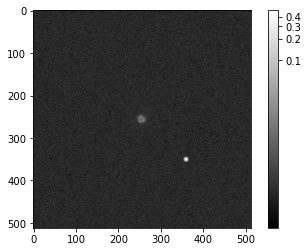

In [176]:
plt.imshow(g_data, cmap='gray', norm=norm)
plt.colorbar()

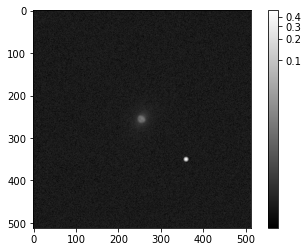

In [177]:
plt.imshow(r_data, cmap='gray', norm=norm)
plt.colorbar()

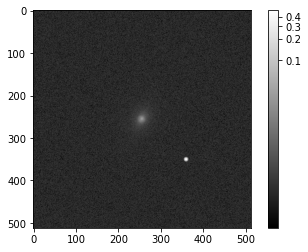

In [178]:
plt.imshow(z_data, cmap='gray', norm=norm)
plt.colorbar()

In [179]:
print('Min:', np.min(g_data))
print('Max:', np.max(g_data))
print('Mean:', np.mean(g_data))
print('Stdev:', np.std(g_data))

Min: 1.6296359e-07
Max: 0.49159986
Mean: 0.0010485101
Stdev: 0.0031226643


In [180]:
print('Min:', np.min(r_data))
print('Max:', np.max(r_data))
print('Mean:', np.mean(r_data))
print('Stdev:', np.std(r_data))

Min: 2.1896221e-07
Max: 0.5512196
Mean: 0.0005573882
Stdev: 0.0032627052


In [181]:
print('Min:', np.min(z_data))
print('Max:', np.max(z_data))
print('Mean:', np.mean(z_data))
print('Stdev:', np.std(z_data))

Min: 6.0999434e-07
Max: 0.62302494
Mean: 0.0010777509
Stdev: 0.0035180072


In [182]:
print(type(g_data.flatten()))
print(g_data)
print(g_data.flatten())
print(len(g_data))

<class 'numpy.ndarray'>
[[1.4136357e-03 8.2474825e-04 9.4129855e-04 ... 1.0659848e-03
  1.5265399e-03 1.8269882e-03]
 [1.1787271e-03 6.0571532e-05 9.3058927e-04 ... 1.8177630e-03
  1.5357145e-03 1.3688602e-04]
 [4.3007897e-04 1.1088753e-03 1.1194039e-04 ... 5.7524117e-04
  6.1498242e-05 5.0435745e-04]
 ...
 [1.4695572e-04 6.8003789e-04 1.8970028e-03 ... 1.4970166e-03
  1.2164160e-03 1.1444869e-03]
 [1.2320331e-03 1.2500305e-03 7.4149267e-04 ... 9.0330717e-04
  4.2296594e-04 1.0944667e-03]
 [1.2802592e-03 2.3637178e-04 5.3310773e-04 ... 7.7094720e-04
  9.4732252e-04 5.9501681e-04]]
[0.00141364 0.00082475 0.0009413  ... 0.00077095 0.00094732 0.00059502]
512


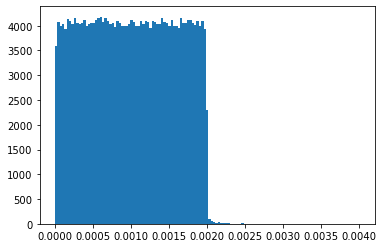

In [183]:
g_histogram = plt.hist(g_data.flatten(), range=[0, 4e-3], bins='auto')

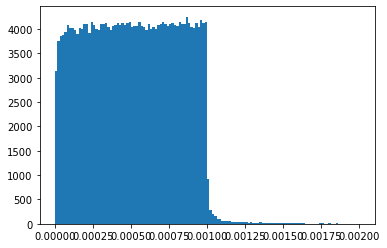

In [184]:
r_histogram = plt.hist(r_data.flatten(),range=[0, 2e-3], bins='auto')

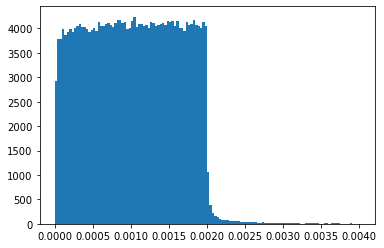

In [185]:
z_histogram = plt.hist(z_data.flatten(),range=[0,4e-3], bins='auto')

In [186]:
image_list = [g_data, r_data, z_data]
stacked_image = np.zeros(shape=image_list[0].shape)
for image in image_list:
    stacked_image += image

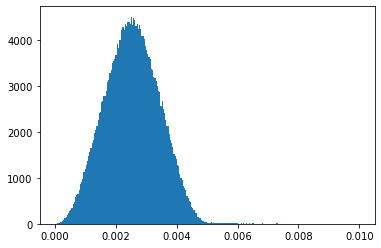

In [187]:
image_hist = plt.hist(stacked_image.flatten(),range=[0,10e-3], bins='auto')

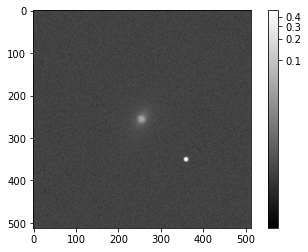

In [188]:
plt.imshow(stacked_image, cmap='gray', norm=norm)
plt.colorbar()

In [189]:
# select a region around the star
brightest_pxl = np.max(z_data)
pos = np.where(z_data == brightest_pxl)
xpos, ypos = pos[0], pos[1]
# select a square region to contain this star (length=30)
size = 3
# in what follows, we will first use the cropped image that contains the star to find the PSF
# then we will use the PSF to find the rescaling factor
star_cropped_z = z_data[int(xpos)-size:int(xpos)+size][:,int(ypos)-size:int(ypos)+size]
star_cropped_g = g_data[int(xpos)-size:int(xpos)+size][:,int(ypos)-size:int(ypos)+size]


In [190]:
def convolve_rescale_star(x):
    """
    Convolve the original image with a Gaussian kernel, then rescale it
    ----------
    Input:
        x: 1d list of length 2
           x[0]: the width of Gaussian kernel
           x[1]: the rescaling factor
    ----------
    Output:
        diffsum: float
                 the sum of the the residual pixel values between convolved, rescaled z-band image
                 and original g-band image
    """
    # first smooth the image
    img = star_cropped_z
    # make the sure kernel has a positive size:
    if x[0] > 0:
        kernel = Gaussian2DKernel(x_stddev=x[0])
    else:
        kernel = Gaussian2DKernel(x_stddev=2)
    z_conv = convolve(img, kernel)
    # then rescale it
    z_final = z_conv * x[1]
    # finally subtract it from g-band image
    diff = (z_final - star_cropped_g)**2
    diffsum = np.sqrt(np.sum(diff))
    
    return diffsum

In [191]:
# use Nelder-Mead to find the minimization; x0 is an initial guess: (width, scaling factor)
res = opt.minimize(convolve_rescale_star, x0=[5, 0.3], method='Nelder-Mead')
width, f_rescale = res.x[0], res.x[1]
print(width, f_rescale)

0.9355205971135312 1.0599853879224297


In [192]:
# select a region that contains the central lens galaxy
length = len(z_data)
xpos, ypos = length/2, length/2
# select a square region to contain this lens galaxy
size = 50
lens_cropped_z = z_data[int(xpos)-size:int(xpos)+size][:,int(ypos)-size:int(ypos)+size]
lens_cropped_g = g_data[int(xpos)-size:int(xpos)+size][:,int(ypos)-size:int(ypos)+size]

In [317]:
def convolve_rescale_lens(x, lens_cropped_g, lens_cropped_z):
    """
    Similar to the previous function, but instead of using the portion of the image that contains the star,
    we use the central portion that contains the lens
    We also use the width of the Gaussian kernel derived in the previous step
    We only need to solve for the rescaling factor here; x is one-dimensional
    """
    # first smooth the image
    img = lens_cropped_z
    # use the kernel whose width we derived earlier
    kernel = Gaussian2DKernel(x_stddev=width)
    z_conv = convolve(img, kernel)
    # then rescale it
    z_final = z_conv * x
    # finally subtract it from g-band image
    lens_cropped_g_sort = np.array(np.sort(lens_cropped_g))
    counter = 0
    for i in range(3):
        if counter>0:
            lens_cropped_g_sort[((counter+1)*(-10)):, ((counter+1)*(-10)):] = 0
            counter+=1
        else: 
            lens_cropped_g_sort[-10:, -10:] = 0
            counter+=1
        diff = ((z_final - lens_cropped_g_sort)**2)
        diffsum = np.sqrt(np.sum(diff))
    return diffsum

In [318]:
print(convolve_rescale_lens(4, lens_cropped_g, lens_cropped_z))

# use Nelder-Mead to find the minimization; x0 is an initial guess: scaling factor
res = opt.minimize(convolve_rescale_lens, x0=4, args = (lens_cropped_g, lens_cropped_z), method='Nelder-Mead')
f_rescale = res.x[0]
# and this will be the final answer!
print(width, f_rescale)

1.0166233
0.9355205971135312 0.2731445312499967


In [319]:
# convert sigma to PSF: PSF = 2.355 * sigma
psf = width * 2.355
print('PSF = {:2f}; scaling factor = {:2f}'.format(psf, f_rescale))

PSF = 2.203151; scaling factor = 0.273145


In [320]:
kernel = Gaussian2DKernel(x_stddev=width)
z_conv = convolve(z_data, kernel)
zband_final = z_conv *f_rescale
gz = g_data-zband_final

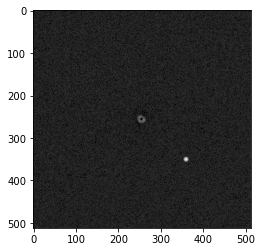

In [321]:
plt.imshow(gz, cmap='gray', norm=norm)

In [322]:
rz = r_data-zband_final

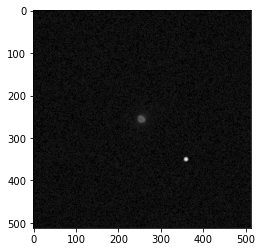

In [323]:
plt.imshow(rz, cmap='gray', norm=norm)

In [ ]:
#Cursed code below- be wary

In [76]:
"""In this section of code, we attempt to find the scale factor using an MCMC sampler to test efficiency and give more flexibility. 
I will continue to use the convolved, rescaled star data."""

'In this section of code, we attempt to find the scale factor using an MCMC sampler to test efficiency and give more flexibility. \nI will continue to use the convolved, rescaled star data.'

In [104]:
ndim, nwalkers, nsteps = 1, 25, 1000
p0 = 1. + np.random.normal(scale=0.1, size=ndim * nwalkers).reshape((nwalkers, ndim))
sampler = emcee.EnsembleSampler(nwalkers, ndim, convolve_rescale_lens, args=[])
pos, prob, state = sampler.run_mcmc(p0, nsteps)
chain = sampler.chain

In [ ]:
def convolve_rescale_lens_model(lens_cropped_z, lens_cropped_g, width, x):
    """
    Similar to the previous function, but instead of using the portion of the image that contains the star,
    we use the central portion that contains the lens
    We also use the width of the Gaussian kernel derived in the previous step
    We only need to solve for the rescaling factor here; x is one-dimensional
    """
    # first smooth the image
    img = lens_cropped_z
    # use the kernel whose width we derived earlier
    kernel = Gaussian2DKernel(x_stddev=width)
    z_conv = convolve(img, kernel)
    # then rescale it
    z_final = z_conv * x
    # finally subtract it from g-band image
    diff = (z_final - lens_cropped_g)**2
    diffsum = np.sqrt(np.sum(diff))
    return diffsum

In [ ]:
yerr = .05
def lnlike_model(lens_cropped_z, lens_cropped_g, x, width, yerr):
    lnlike = -0.5*(np.sum(((lens_cropped_z-lens_cropped_g) - convolve_rescale_lens_model(lens_cropped_z, lens_cropped_g, width, x))/yerr)**2
    return lnlike

In [ ]:
def lnprior(lens_cropped_z, lens_cropped_g, width, x):
    #??
    if width < 3 and width>0:
        return 0.0
    else:
        return -np.inf

In [ ]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(lens_cropped_z, lens_cropped_g, width, x)
    if not #check if lp is infinite:
        return -np.inf
    return lp + lnlike(theta, x, y, yerr) #recall if lp not -inf, its 0, so this just returns likelihood


In [ ]:
def lnrosenbrock(x, a=1., b=100., c=1.):
    """\ln of the Rosenbrock "banana" distribution
    x is a numpy vector of points in 2 or more dimensional space
    """
    return -c * sum(b*(x[1:]-x[:-1]**2.0)**2.0 + (a-x[:-1])**2.0)